In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,LabelEncoder


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
##concatenate train and test data
df = pd.concat(([train.drop('SalePrice', axis=1), test]), axis=0)

## Handle missing values
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(exclude=['object']).columns

# Fill missing values for categorical columns with mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing values for numerical columns with mean
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

C:\Users\Raghava-Reddy\AppData\Local\Temp\ipykernel_2112\2940664154.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\Raghava-Reddy\AppData\Local\Temp\ipykernel_2112\2940664154.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [5]:
##label encoding of categorical features
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,0,3,3,0,...,0,0,0,2,2,0,2,2008,8,4
1,2,20,3,80.0,9600,1,0,3,3,0,...,0,0,0,2,2,0,5,2007,8,4
2,3,60,3,68.0,11250,1,0,0,3,0,...,0,0,0,2,2,0,9,2008,8,4
3,4,70,3,60.0,9550,1,0,0,3,0,...,0,0,0,2,2,0,2,2006,8,0
4,5,60,3,84.0,14260,1,0,0,3,0,...,0,0,0,2,2,0,12,2008,8,4


In [6]:
##feature engineering
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBathrooms'] = df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
df['TotalArea'] = df['GrLivArea'] + df['TotalSF'] + df['TotalPorchSF']


<Axes: xlabel='SalePrice', ylabel='Count'>

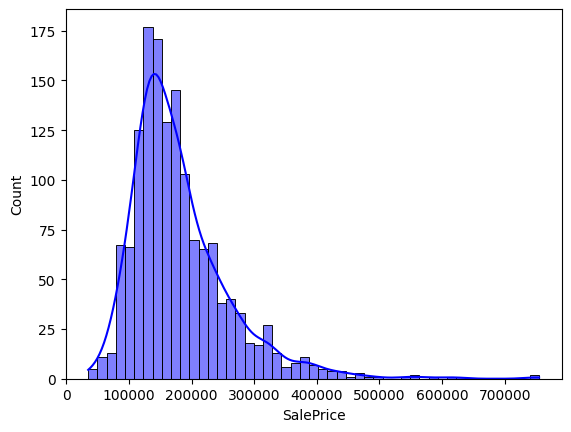

In [7]:
## target variable
y = train['SalePrice']

##check if the data is normally distributed...Here it is not normal, so we use log transformation
sns.histplot(y, kde=True, color='blue', label='Actual Sale Price')

<Axes: xlabel='SalePrice', ylabel='Count'>

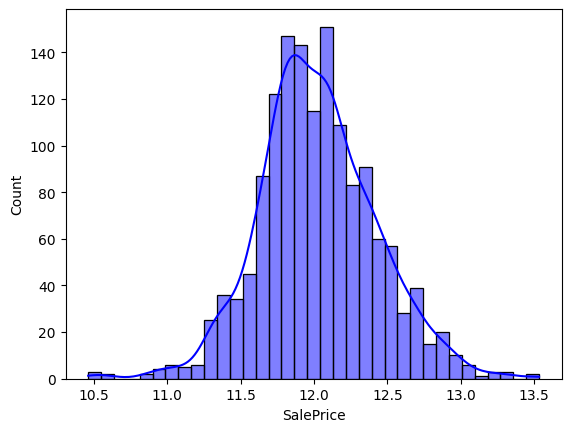

In [8]:
## Log transformation of the target variable since the target variable is not distrubuted normally
y = np.log1p(y)
sns.histplot(y, kde=True, color='blue', label='Actual Sale Price')

In [9]:
##split the data  into train and test
X = df[:len(train)]
X_test = df[len(train):]


In [10]:
##define models for training
cat_model = CatBoostRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbose=0)
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbosity=0)
rf_model = RandomForestRegressor(random_state=42)

In [11]:
#perform 5-fold cross-validation
def get_oof_predictions(model,X,y):
    oof_preds = np.zeros(X.shape[0])
    kf = KFold(n_splits = 5,shuffle=True, random_state=42)
    for train_idx,val_idx in kf.split(X):
        X_train,X_val = X.iloc[train_idx],X.iloc[val_idx]
        y_train,y_val = y.iloc[train_idx],y.iloc[val_idx]
        model.fit(X_train, y_train)
        oof_preds[val_idx] = model.predict(X_val)
    return oof_preds

cat_oof = get_oof_predictions(cat_model, X, y)
xgb_oof = get_oof_predictions(xgb_model, X, y)
rf_oof = get_oof_predictions(rf_model, X, y)

##combine the out-of-fold predictions
stacked_train = np.column_stack((cat_oof, xgb_oof, rf_oof))



In [12]:
# Train a meta-model on the stacked features
meta_model = Ridge(alpha=0.01)
meta_model.fit(stacked_train, y)

##train the individual models on the full training data
cat_model.fit(X, y)
xgb_model.fit(X, y)
rf_model.fit(X, y)

# Predict on test data using the individual models
cat_test_preds = cat_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)

## Combine the test predictions
stacked_test = np.column_stack((cat_test_preds, xgb_test_preds, rf_test_preds))

# Make final predictions using the meta-model
final_preds = meta_model.predict(stacked_test)

# Convert predictions back to original scale
final_preds = np.expm1(final_preds)


In [13]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
# Evaluate the model on the training data
evaluate_model(y, meta_model.predict(stacked_train))

Mean Squared Error: 0.01581381940737438
R^2 Score: 0.9008229770007496


In [14]:
#submission
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_preds
})
submission.to_csv('submission4.csv', index=False)